In [3]:
import numpy as np
import numpy.linalg as lin
import matplotlib.pyplot as plt
import scipy as sp
import scipy.special as functions
import scipy.signal as sig_tools
import autoregressive_simulations as AR
from BaNonparConnAnaly import *
%matplotlib inline

/vol/optdcc/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
time_step = 0.01
time_period = 4.
AR_coefficient = 0.6
relaxation_coef = -(AR_coefficient - 1)/time_step
connectivity_relaxation = 1/0.15
connectivity_strenght = 0.02/time_step

GPanalysis = GPconnectivityAnalysis()
GPanalysis.initialize_time_parameters(time_step, time_period)
GPanalysis.simulator.dynamic_parameters = {"number_sources": 2,
                                           "connectivity_weigths": np.array([[0, 0],[connectivity_strenght, 0]]),
                                           "connectivity_relaxations_constants": np.array([[0, connectivity_relaxation],[connectivity_relaxation, 0]]),
                                           "moving_average_time_constants": np.array([10**15, 10**15]),
                                           "relaxation_constants": np.array([relaxation_coef, relaxation_coef])}
GPanalysis.simulator.run_sampler(number_samples = 1000)

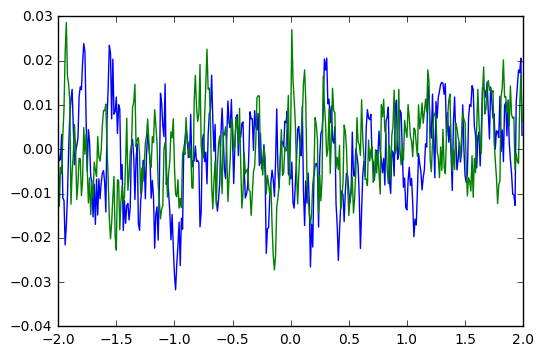

In [5]:
GPanalysis.simulator.plot_sample(sample_index = 1)

In [7]:
# test marginal likelihood (dynamic)
jitter = 10**-15
max_sample = 1000

dynamic_parameters_range = {}
dynamic_parameters_range["relaxation_constant"] = {}
dynamic_parameters_range["relaxation_constant"]["step"] = 1
dynamic_parameters_range["relaxation_constant"]["min"] = 15
dynamic_parameters_range["relaxation_constant"]["max"] = 60

dynamic_parameters_range["amplitude"] = {}    
dynamic_parameters_range["amplitude"]["step"] = 0.001
dynamic_parameters_range["amplitude"]["min"] = 0.001
dynamic_parameters_range["amplitude"]["max"] = 0.03

GPanalysis.samples = GPanalysis.simulator.samples[0:max_sample]
GPanalysis.dynamic_type = "Relaxation"
GPanalysis.learn_dynamic_parameters(dynamic_parameters_range, 
                                    jitter)
GPanalysis.noise_level = float(GPanalysis.dynamic_parameters["amplitude"][1]/np.sqrt(2*GPanalysis.dynamic_parameters["amplitude"][1]))

GPanalysis.covariance_parameters = {"time_scale": 0.25,
                                    "time_shift": 0.01,
                                    "causal": "yes",
                                    "spectral_smoothing": 6*np.pi*2*10**-1}
print "The parameters have been estimated"
GPanalysis.run_analysis()
GPanalysis.compute_connectivity_statistics()



The parameters have been estimated


/vol/optdcc/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/vol/optdcc/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:4645: ComplexWarning: Casting complex values to real discards the imaginary part
  X[0] = start
/vol/optdcc/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:4646: ComplexWarning: Casting complex values to real discards the imaginary part
  X[N + 1] = end
/vol/optdcc/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:4649: ComplexWarning: Casting complex values to real discards the imaginary part
  X[1:N + 1, 1] = y1slice
/vol/optdcc/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:4651: ComplexWarning: Casting complex values to real discards the imaginary part
  X[N + 2:, 1] = y2slice[::-1]


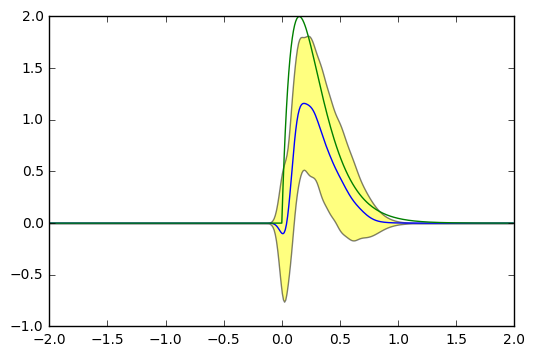

In [8]:
input_region = 1
output_region = 0
GPanalysis.plot_connectivity_statistics(time_range   = GPanalysis.simulator.time_meshgrid["time_range"],
                                        output_index = output_region, 
                                        input_index  = input_region,
                                        error_bars = "standard_deviation")
ground_truth = lambda t: 0.5*(np.sign(t) + 1)*t*np.exp(-t*GPanalysis.simulator.dynamic_parameters["connectivity_relaxations_constants"][0, 1])
plt.plot(GPanalysis.simulator.time_meshgrid["time_range"], GPanalysis.simulator.dynamic_parameters['connectivity_weigths'][input_region, output_region]*ground_truth(GPanalysis.simulator.time_meshgrid["time_range"])/np.max(ground_truth(GPanalysis.simulator.time_meshgrid["time_range"])))
#plt.ylim([-1.3*GPanalysis.simulator.dynamic_parameters['connectivity_weigths'][0, 1],1.3*GPanalysis.simulator.dynamic_parameters['connectivity_weigths'][0, 1]])

# you should integrate the plotting functions with the simulator # (some work to do: not urgent)

In [9]:
mean_parameters = 0
TwoMom_parameters = 0
max_time_lag = 100
for sample in GPanalysis.simulator.samples:
    model = VAR.VAR(sample.T)
    results = model.fit(maxlags=max_time_lag)
    mean_parameters += (1/time_step)*results.params[::2,0]/len(GPanalysis.simulator.samples)
    TwoMom_parameters += (1/time_step)**2*results.params[::2,0]**2/len(GPanalysis.simulator.samples)
sd_parameters = np.sqrt(TwoMom_parameters - mean_parameters**2)

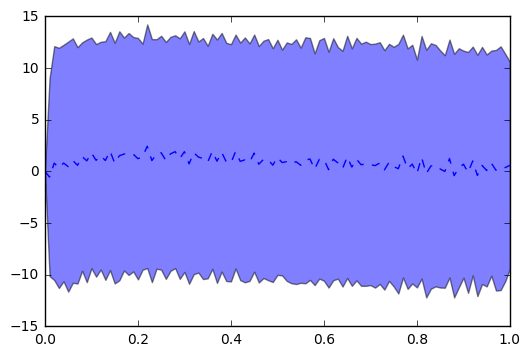

In [10]:
time_range = np.arange(0, time_period/2, time_step)
time_range = time_range[0:max_time_lag + 1]
fig, ax = plt.subplots(1)
plt.plot(time_range, mean_parameters, linestyle = '--')
lower_bound = mean_parameters - sd_parameters
upper_bound = mean_parameters + sd_parameters
ax.fill_between(time_range, lower_bound.flatten(), upper_bound.flatten(), facecolor='blue', alpha=0.5)

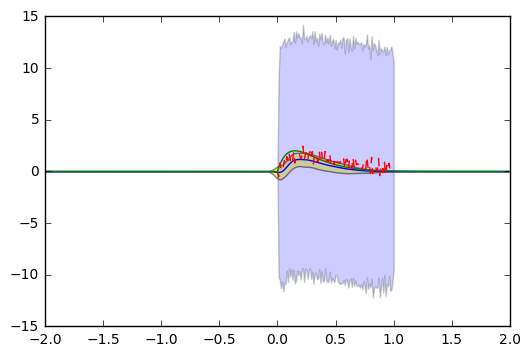

In [11]:
input_region = 1
output_region = 0
GPanalysis.plot_connectivity_statistics(time_range   = GPanalysis.simulator.time_meshgrid["time_range"],
                                        output_index = output_region, 
                                        input_index  = input_region,
                                        error_bars = "standard_deviation")
ground_truth = lambda t: 0.5*(np.sign(t) + 1)*t*np.exp(-t*GPanalysis.simulator.dynamic_parameters["connectivity_relaxations_constants"][0, 1])
plt.plot(GPanalysis.simulator.time_meshgrid["time_range"], GPanalysis.simulator.dynamic_parameters['connectivity_weigths'][input_region, output_region]*ground_truth(GPanalysis.simulator.time_meshgrid["time_range"])/np.max(ground_truth(GPanalysis.simulator.time_meshgrid["time_range"])))
plt.plot(time_range, mean_parameters, linestyle = '--')
lower_bound = mean_parameters - sd_parameters
upper_bound = mean_parameters + sd_parameters
plt.fill_between(time_range, lower_bound.flatten(), upper_bound.flatten(), facecolor='blue', alpha=0.2)